# 3.8.1: Pennies Falling Redux

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


So far the differential equations we've worked with have been *first order*, which means they involve only first derivatives.  If the denominator of the equation is a $dt$, these can generally be seen as straight-forward rate equations.

<br>

In this notebook, we turn our attention to *second order* differential equations, which can involve both first and second derivatives.  We'll revisit the falling penny example we started the course with, and use `run_solve_ivp` to find the position and velocity of the penny as it falls, with and without air resistance.

## The Second Law of Motion as a Second Order DEQ

First order differential equations (DEs) can be written 

<br>

$$\frac{dy}{dx} = G(x, y)$$ 

<br>

where $G$ is some function of $x$ and $y$.  If the denominator is $dt$, then we call these rate equations: how fast is some variable changing with time?  Second order DEs can be written 

<br>

$$\frac{d^2y}{dx^2} = H(x, y)$$

<br>

where $H$ is a function of $x$ and $y$.  While a first order DE tells us how fast a variable is changing, a second order DE tells us how fast a *rate* is changing.  

What does that mean?  In this chapter, we will work with one of the most famous and useful second order DEs, the second law of motion: 

<br>

$$\Sigma F = m a$$ 

<br>

where $\Sigma F$ is the sum of forces on an object, $m$ is the mass of the object, and $a$ is its acceleration.

<br>

This equation might not look like a differential equation.  But let's see how it actually is.  Start with velocity, which is a rate equation: the change in position with respect to time:

<br>

$$v = \frac{dy}{dt}$$

<br>

Now recognize that acceleration is the change in velocity with respect to time, and so another rate equation:

<br>

$$a = \frac{dv}{dt}$$

<br>

So acceleration is the rate of change of a rate: how fast is the rate of position changing with time:

<br>

$$a = \frac{\frac{dy}{dt}}{dt} = \frac{d^2y}{dt^2}$$

<br>

Now we can rewrite the second law as a second order DEQ:

<br>

$$\frac{d^2y}{dt^2} = \Sigma F / m$$   

<br>

While velocity tells us how the variable *position* is changing with time, acceleration tells us how fast *velocity* is changing with time.  It is the rate of change of velocity, or more fundamentally, it is the rate of change of the rate of change of position (!).  That makes it a second order DE.

✅ Active reading:  Consider the metric base units for velocity ($\frac {m}{s}$) and acceleration ($\frac {m}{s^2}$).  The units for acceleration seem odd, but we can also write them like this:

$$\frac {\frac{m}{s}}{s}$$

Explain in your words how this form of the units expresses acceleration as a rate of change of a rate of change.  If I have a constant acceleration of 10 $m/s^2$ and an initial velocity of 5 $m/s$, what is my velocity after 3 seconds?

✅ ✅ Answer here.

## Dropping Pennies

As a first example, let's get back to the penny falling from the Empire State Building. We will implement two models of this system: first without air resistance, then with.

<br>

Given that the Empire State Building is 381 m high, and assuming that
the penny is dropped from a standstill, the initial conditions are:

In [ ]:
height = 381
init = pd.Series(dict(y=height, v=0))

where `y` is height above the sidewalk and `v` is velocity.  I'll put the initial conditions in a `System` object, along with the magnitude of acceleration due to gravity, `g`, and the duration of the simulations, `t_end` (an arbitrary 10 seconds).

In [ ]:
gravity = 9.8
system = dict(init=init, g=gravity, t_end=10)

Now we need a slope function, and here's where things get tricky. As we have seen, `run_solve_ivp` can solve systems of first order DEs, but the second law is a second order DE. 

<br>

We've got some tricks up our sleeve, though! Remember that both velocity and acceleration can be described as first order rate equations, as we saw above.  And since velocity and acceleration depend on each other, we can rewrite the second law as a system of first order ODEs:

<br>

$$v= \frac{dy}{dt}  \qquad a= \frac{dv}{dt}$$ 

<br>

This set of equations embodies the idea we mentioned earlier: acceleration is the rate of change of the rate of change of position.

<br>

More concretely, this system allows us to translate the second law into a slope function:

In [ ]:
def slope_func(t, state, system):
    y, v = state

    dydt = v
    dvdt = -system['g']
    
    return dydt, dvdt

As usual, the parameters are a time stamp, a `state` object, and a `system` object.

* The first line unpacks the state variables, `y` and `v`.

* The next two lines compute the derivatives of the state variables, `dydt` and `dvdt`.
The derivative of position is velocity, and the derivative of velocity is acceleration.
In this case, $a = -g$, which indicates that acceleration due to gravity is in the direction of decreasing $y$. 

* `slope_func` returns a sequence containing the two derivatives.

Let's test the function with the initial conditions:

In [ ]:
dydt, dvdt = slope_func(0, system['init'], system)
dydt, dvdt

(0, -9.8)

The result is 0 m/s for velocity and -9.8 m/s$^2$ for acceleration.  Now we call `run_solve_ivp` like this:

In [ ]:
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

`results` is a `DataFrame` with two columns: `y` contains the height of the penny; `v` contains its velocity.
Here are the first few rows.

In [ ]:
results.head()

,y,v
0.0,381.000,0.00
0.1,380.951,-0.98
0.2,380.804,-1.96
0.3,380.559,-2.94
0.4,380.216,-3.92


We can plot the results like this:

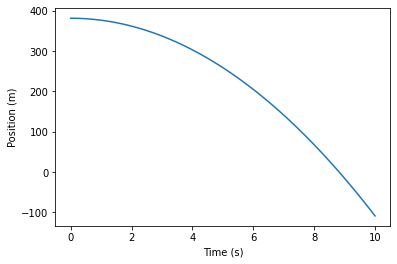

In [ ]:
results.y.plot(xlabel='Time (s)',
         ylabel='Position (m)');

Since acceleration is constant, velocity increases linearly and position decreases quadratically; as a result, the height curve is a parabola.  The last value of `results.y` is negative, which means we ran the simulation too long. 

In [ ]:
results.iloc[-1].y

-108.99999999999983

One way to solve this problem is to use the results to
estimate the time when the penny hits the sidewalk: we could keep running the simulation until the end `y` value was close to zero, or even write a code that would do that for us.  But there is a better way....

## Events

As an option, `run_solve_ivp` can take an *event function*, which
detects an "event", like the penny hitting the sidewalk, and ends the
simulation.  The "event" occurs when the assigned variable of a continuous function reaches 0. 

<br>

Event functions take the same parameters as slope functions, `t`, `state`, and `system`. They should return a value that passes through `0` when the event occurs. Here's an event function that detects the penny hitting the sidewalk:

In [ ]:
def event_func(t, state, system):
    y, v = state
    return y

The return value is the height of the penny, `y`, which passes through
`0` when the penny hits the sidewalk.  We pass the event function to `run_solve_ivp` like this:

In [ ]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

The simulation stops when the value of `y` reaches zero.  That means that the last set of values (`t`,`y`,`v`) for `results` will be the values when the penney hits the ground.  So we can get the flight time like this:

In [ ]:
t_end = results.index[-1]
t_end

8.817885349720553

And the final velocity like this:

In [ ]:
y, v = results.iloc[-1]
y, v

(0.0, -86.41527642726145)

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at about 86 m/s. So it's a good thing there is air resistance.

---

<br>

## Summary

In this chapter, we wrote the second law of motion, which is a second order DE, as a system of first order DEs.
Then we used `run_solve_ivp` to simulate a penny dropping from the Empire State Building in the absence of air resistance.

<br>

This is the same answer we got using the kinematic equation back in the first chapter, right?  So why is it better?  The answer is that we can add other forces to our equation, like air resistance, and get more realistic answers.

<br>

---

### Exercise 1

Here's a question from a website called [*Ask an Astronomer*](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

> "If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Use `run_solve_ivp` to answer this question.

Here are some suggestions about how to proceed:

1.  Look up the Law of Universal Gravitation and any constants you need.  You can avoid conversion problems by working entirely in SI units: meters, kilograms, and Newtons.

2.  When the distance between the Earth and the Sun gets small, this system behaves badly, so you should use an event function to stop when the surface of Earth reaches the surface of the Sun.

3. Express your answer in days, and plot the results as millions of kilometers versus days.

4. Assume that the sun will not move a lot, so only need to consider the velocity and the position of the earth.   But if you'd like to challenge yourself, consider that the gravitational force would pull both on the earth and the sun: to be more accurate we'd need to consider the movement of both the earth and the sun.  If you do this, check at the end whether the assumption that the sun doesn't move much is valid.

Much of the code will echo the penny problem in the chapter (especially if you assume the sun doesn't move), so don't try to start from scratch!



In [ ]:
# Define your parameters (radii and mass of the earth and sun, 
# gravitational constant G (not g!), initial distance between the 
# objects)
# Use metric base units and the exponential form (e.g, mass_earth = 5.97e24)
r_earth = 6.378e6       # radius of earth, m
r_sun = 6.9634e8        # radius of sun, m
init_pE = 1.4722e11     # initial position of earth, in m
m_earth = 5.972e24      # mass of the earth, kg
m_sun = 1.989e30        # mass of the sun, kg
G_constant = 6.674e-11  # universal gravitational constant, m^3/(s^2 kg)

# Create an initial state Series called 'init' with position and velocity
# If you are keeping track of the sun, call its initial position '0'
init = pd.Series(dict(pE=init_pE, vE = 0, pS = 0, vS = 0))

# Create a system dictionary with the system parameters
# Include a 't_end=1e8'
system = dict(init=init,r_earth = r_earth,
                r_sun = r_sun,
                m_earth = m_earth,
                m_sun = m_sun, 
                G_constant = G_constant,
                t_end=1e8)

In [ ]:
# Define a slope function
def slope_func(t, state, system):
    # Unpack your state and system
    pE,vE,pS,vS = state
    G, mE, mS = system['G_constant'], system['m_earth'], system['m_sun']
    rE,rS = system['r_earth'], system['r_sun']

    # Define the force between the two objects
    d= pE-pS
    F = (G * mE * mS)/(d**2)

    # Define the dydt and dvdt for earth (look at penny example for help)
    # You'll need Newton's law for dvdt (and make the sign: which direction
    # is the force pulling?)
    dydt_E = vE
    dvdt_E = -F/mE
    
    # If you are keeping track of the sun, define dydt and dvdt for su
    dydt_S = vS
    dvdt_S = F/mS
    
    # return dydt and dvdt for earth (and sun, if applicable)
    # Be sure they are in the same order as the state variables!
    return dydt_E, dvdt_E, dydt_S, dvdt_S

In [ ]:
# Test your slope function for the initial conditions
# Your dvdt for earth should be about -0.006
slope_func(0,init,system)

(0.0, -0.006124735788421156, 0.0, 0)

In [ ]:
# Define an appropriate event_func
# This should be an equation that is equal to zero when the surface
# of the sun is touching the surface of the earth

def event_func(t, state, system):
    pE,vE,pS,vS = state
    return pE - pS - system['r_earth'] - system['r_sun']

In [ ]:
# Run run_solve_ivp
# Check the penny problem to make sure your format is correct
results, details = run_solve_ivp(system, slope_func,events=event_func)
results


,pE,vE,pS,vS
0.000000e+00,1.472200e+11,0.000000,0.0,0.0
5.444887e+04,1.472109e+11,-333.498644,0.0,0.0
1.088977e+05,1.471837e+11,-667.079835,0.0,0.0
1.633466e+05,1.471383e+11,-1000.827929,0.0,0.0
2.177955e+05,1.470747e+11,-1334.824258,0.0,0.0
...,...,...,...,...
5.227091e+06,2.927076e+10,-85200.547716,0.0,0.0
5.281540e+06,2.436937e+10,-95389.125526,0.0,0.0
5.335989e+06,1.878353e+10,-110986.249490,0.0,0.0
5.390438e+06,1.201075e+10,-142615.711044,0.0,0.0


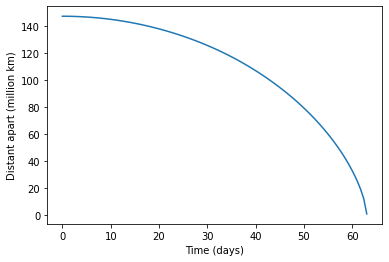

In [ ]:
# Plot the distance between the earth and the sun over time
# This should be the results from run_solve_ivp, but note that
# the results will be a DataFrame with all of your state variables

# Find the distance between sun and earth in millions of kilometers
d_coll = (results.pE - results.pS)/1e9

# Convert index from seconds to days
d_coll.index = d_coll.index/(24 * 60 * 60)
d_coll.plot(xlabel='Time (days)',
         ylabel='Distant apart (million km)');


In [ ]:
# Determine the final values for the velocity of the earth
# and the time elapsed

pE,vE,pS,vS = results.iloc[-1]
print('When the sun and earth collide:')
print('   The earth has travelled ', (init_pE-pE)/(1e9), ' million km')
print('   The sun has travelled ', (pS)/(1e6), ' km')
print('   The sun has a velocity of ', vS, 'm/s')
print('   The earths velocity is ', -vE/1000, 'km/s')
print('   The time elapsed before the collision is ', 
      results.index[-1]/(24*3600), 'days')

# Notice that it would take a fraction of a second for the earth to 
# travel the additional 0.4 km that the sun travelled during the
# elapsed time.

When the sun and earth collide:
   The earth has travelled  146.517282  million km
   The sun has travelled  0.0  km
   The sun has a velocity of  0.0 m/s
   The earths velocity is  613.5351657727383 km/s
   The time elapsed before the collision is  63.01952347982913 days
